In [1]:
# "PROGRAMA GIRDI OLARAK VERILEN HABER METINLERININ KATEGORISINI CIKTI OLARAK VEREN PROGRAM PROJESI"

import pandas as pd      # veri analizi ve islemler icin
import nltk              # metinleri analiz etmek ve islemek icin
import re                # metinler islemleri icin

# CountVectorizer - metin verilerini bag of words modeline göre sayisal vektörlere donusturmek icin
# (her bir metin, icindeki kelimelerin frekanslarıyla temsil edilir.)

# TF-IDF Yontemi - sıkca gecen ama bilgilendirici olmayan kelimelerin etkisini azaltir 
# ve nadir ama bilgilendirici kelimelerin onemini artırır.

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
#NEDEN NAIVE BAYES?
# - AZ VERI ILE IYI OLUYO
# - NLP DE IYI OLUYO
# - HIZLICA BITIRELIM ISTE
# - Alternatif - SVM, KNN, RF belki
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline # tek islem zinciri uzerinde yapma
import matplotlib.pyplot as plt  # veri görsellestirme
import joblib
import seaborn as sns

# NLTK durak kelimeleri indirme (ilk kez calıstırıyorsak)
# nltk.download('stopwords')    

In [3]:
# Veri yükleme
df = pd.read_excel("C:/Users/Lenovo/Desktop/TurkceHaberMetinleriniSiniflandirma-master/TurkceHaberMetinleriniSiniflandirma-master/data/gazete.xlsx")

In [7]:
df.head()

,kategori,icerik
0,magazin,SAPIĞIN BİLE GURURSUZU BANA DENK GELDİ Ece Erk...
1,magazin,"Çekim dönüşü Kenan İmirzalıoğlu, geçtiğimiz ak..."
2,magazin,Paylaştığı fotoğraf Twitter'da olay oldu! Vict...
3,magazin,"DANIŞTAY, 5 DAKİKA SEVİŞMEYİ UZUN BULDU Danışt..."
4,magazin,Yağmur ve Emre dudak dudağa Kanal D'nin yeni y...


In [9]:
len(df)

5577

In [13]:
# Türkçe durak kelimeler (stopwords) listesi
stop_word_list = nltk.corpus.stopwords.words('turkish')

- Özel karakterleri kaldırıyoruz.
- Tüm metinleri küçük harfe çeviriyoruz.
- Başındaki ve sonundaki boşlukları kaldırıyoruz.

In [15]:
# Haber içeriklerini temizleme
docs = df['icerik']
docs = docs.map(lambda x: re.sub(r"[-()\"#/@;:<>{}+=~|.!?,]", '', x))
docs = docs.map(lambda x: x.lower())
docs = docs.map(lambda x: x.strip())

In [17]:
# Durak kelimeleri kaldıriyore
def token(values):
    filtered_words = [word for word in values.split() if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

In [19]:
# Durak kelimeler temizliyore
docs = docs.map(lambda x: token(x))
df['icerik'] = docs

- makine öğrenmesi algoritmasının verilerile calısabilmesi icin kategorik verileri sayisal degerlere donusturuyoruzz

In [21]:
# Kategorileri sayısal değerlere dönüştürmek
df["kategori_id"] = df["kategori"].factorize()[0]  # kategorileri 0,1..5 diye numaralandırma

In [ ]:
- kategorileri ve bunlara karsılık gelen sayisal degerler icin dataframe olusturuyoruz

In [23]:
# Kategori ve kategori ID'si eşleşmeleri
kategori_id_df = df[['kategori', 'kategori_id']].drop_duplicates().sort_values('kategori_id')
kategori_to_id = dict(kategori_id_df.values)
id_to_kategori = dict(kategori_id_df[['kategori_id', 'kategori']].values)

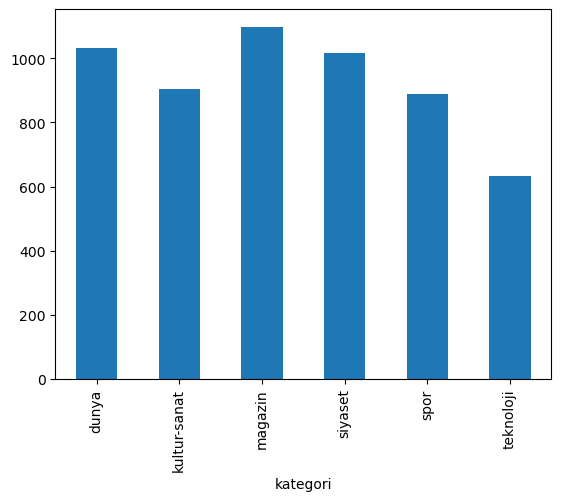

In [25]:
# Kategori dağılımını görselleştirme
df.groupby('kategori').kategori_id.count().plot.bar(ylim=0)
plt.show()

In [27]:
# Özellikler (X) ve hedefler (y)
X = df["icerik"]
y = df["kategori_id"]

In [29]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [31]:
# Makine öğrenmesi pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),        # Metin verilerini kelime frekanslarına göre vektörize eder
    ('tfidf', TfidfTransformer()),      # Vektörize edilmiş kelime frekanslarını TF-IDF skorlarına dönüştürür
    ('clf', MultinomialNB(alpha=1)),    # Naive Bayes sınıflandırıcısını kullanarak model oluşturur # sifir olasilik pr. için
])

# Model eğitimi
text_clf.fit(X_train, y_train)

# Test seti tahminleri
y_pred = text_clf.predict(X_test)

In [33]:
# Modelin doğruluğunu hesaplama
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

# Performans raporu
print(classification_report(y_test, y_pred, target_names=df['kategori'].unique()))

# Hata matrisi oluşturma
conf_mat = confusion_matrix(y_test, y_pred)

Model Doğruluğu: 0.86
              precision    recall  f1-score   support

     magazin       0.77      0.92      0.84       225
       dunya       0.82      0.89      0.85       207
        spor       0.97      0.92      0.95       173
     siyaset       0.89      0.92      0.90       216
kultur-sanat       0.89      0.75      0.82       183
   teknoloji       0.97      0.68      0.80       112

    accuracy                           0.86      1116
   macro avg       0.89      0.85      0.86      1116
weighted avg       0.87      0.86      0.86      1116



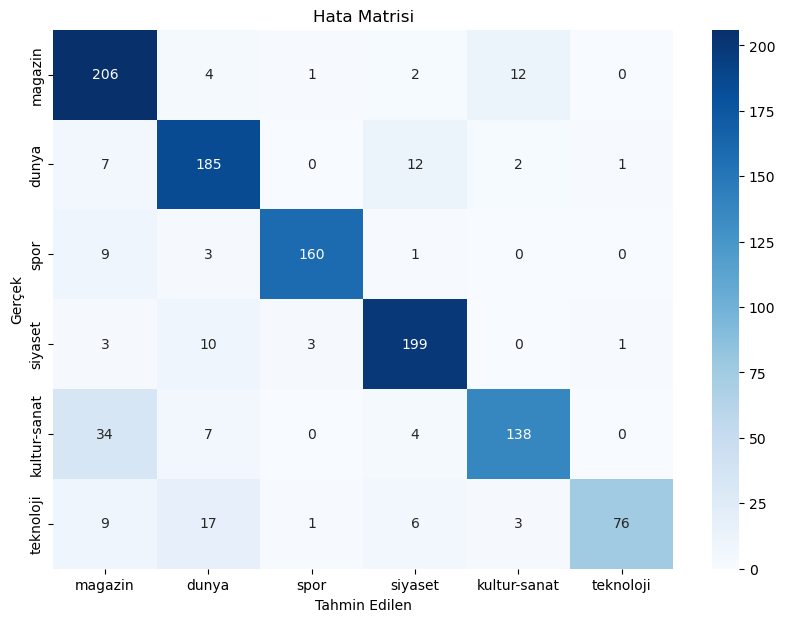

In [35]:
# Hata matrisini görselleştirme
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=kategori_id_df['kategori'].values, 
            yticklabels=kategori_id_df['kategori'].values,
            cmap='Blues')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin Edilen')
plt.title('Hata Matrisi')
plt.show()

In [37]:
# Modeli kaydetme
joblib.dump(text_clf, "NB_gazete_model.pkl")

# Modeli yükleme
NB_gazete_model = open("NB_gazete_model.pkl", "rb")
model = joblib.load(NB_gazete_model)

In [39]:
# Yeni metinler üzerinde tahmin yapma
texts = [
    """aptığı ve düzenlediği yardımlarla sık sık konuşulan Haluk Levent, Twitter hesabından, "Bir bayram günü kostümü! Bayramınız kutlu olsun" ifadeleriyle hem Ramazan Bayramını kutladı hem de geçmiş yıllara ait bir fotoğrafını paylaştı. Levent'in takipçilerinin büyük ilgi gösterdiği fotoğraf yaklaşık 55 bin beğeni alırken, Haluk Levent'e yanıt türkücü Mahsun Kırmızıgül'den geldi. Yıllar öncesine ait albüm fotoğraflarını Twitter'dan paylaşan Mahsun Kırmızıgül, "Alem yakışıklı görsün. @haluklevent senden daha beterleri var. Bu resimler çekildiğinde ilk heyecanları yaşıyorduk. Hey gidi günler hey" ifadelerini kullandı.""",
    """Wesley Sneijder Galatasaray'a yardımcı antrenör olarak geri dönüyor Galatasaray'da Hasan Şaş'ın istifasının ardından boşalan yardımcı antrenörlük görevine sarı kırmızılıların eski yıldızı Wesley Sneijder'in getirileceği iddia edildi.""",
    """Avrupa'da salgınının en son ulaştığı ülke olan Karadağ'da koronavirüs vakası kalmadı Dünya genelinde yeni tip koronavirüs salgınında hayatını kaybedenlerin sayısı 345 bini aşarken, iyileşen sayısı da 2 milyon 290 bine yaklaştı. Avrupa'da salgınının en son ulaştığı ülke olan Karadağ'da ise aktif vaka kalmadı.""",
    """Recep Tayyip Erdoğan yeni kabineyi duyurdu!""",
    """Yeni girişimcilere büyük fırsatlar sunacağına vaadeden ekonomi bakanı Mehmet Şimşek, kendi kurduğu teknoloji şirketi "Lightinuo" yu halka açık şekilde duyurdu. Şimşek, firmasının Türkiye ekonomisine en çok katkıda bulunacağını düşündüğü için çip üretimi yapacağını belirtti.""",
    """ Hakan Fidan, Rıdvan Dilmen'e 3 milyar liralık araba hediye etti. """,
    """Recep Tayyip Erdoğan Eşiyle görüntülendi"""
]

for text in texts:
    data = [text]
    prediction = model.predict(data)[0]
    print(f"Metin: {text[:50]}...\nTahmin Edilen Kategori: {id_to_kategori[prediction]}\n")

Metin: aptığı ve düzenlediği yardımlarla sık sık konuşula...
Tahmin Edilen Kategori: magazin

Metin: Wesley Sneijder Galatasaray'a yardımcı antrenör ol...
Tahmin Edilen Kategori: spor

Metin: Avrupa'da salgınının en son ulaştığı ülke olan Kar...
Tahmin Edilen Kategori: dunya

Metin: Recep Tayyip Erdoğan yeni kabineyi duyurdu!...
Tahmin Edilen Kategori: siyaset

Metin: Yeni girişimcilere büyük fırsatlar sunacağına vaad...
Tahmin Edilen Kategori: magazin

Metin:  Hakan Fidan, Rıdvan Dilmen'e 3 milyar liralık ara...
Tahmin Edilen Kategori: siyaset

Metin: Recep Tayyip Erdoğan Eşiyle görüntülendi...
Tahmin Edilen Kategori: siyaset

